In [15]:
# weather script
# aug 4th
# open meteo api

# https://open-meteo.com/en/docs?hourly=temperature_2m,apparent_temperature,precipitation,cloud_cover,is_day,sunshine_duration&daily=weather_code,sunrise,sunset,daylight_duration,sunshine_duration,precipitation_sum,precipitation_probability_max,apparent_temperature_max,apparent_temperature_min,temperature_2m_max,temperature_2m_min,precipitation_hours&current=temperature_2m,apparent_temperature,is_day,precipitation,weather_code&latitude=40.74&longitude=-73.87&timezone=auto&past_days=7

In [16]:
! pip install openmeteo-requests
! pip install requests-cache retry-requests numpy pandas

In [17]:
import openmeteo_requests

import pandas as pd
import os
import requests_cache
from retry_requests import retry
from datetime import datetime, timedelta, timezone as dt_timezone
from zoneinfo import ZoneInfo  # to recognize the place by its coordinates
import matplotlib.pyplot as plt


In [18]:
# setup the api client with cache and retry on error
# from the api code

cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [19]:
# weather variables
# single location

url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 40.74,
	"longitude": -73.87,
	"daily": ["weather_code", "sunrise", "sunset", "daylight_duration", "sunshine_duration", "precipitation_sum", "precipitation_probability_max", "apparent_temperature_max", "apparent_temperature_min", "temperature_2m_max", "temperature_2m_min", "precipitation_hours"],
	"hourly": ["temperature_2m", "apparent_temperature", "precipitation", "cloud_cover", "is_day", "sunshine_duration"],
	"current": ["temperature_2m", "apparent_temperature", "is_day", "precipitation", "weather_code"],
	"timezone": "auto",
	"past_days": 7,
}
responses = openmeteo.weather_api(url, params=params)

In [20]:
# set up

weather_code_map = {
    0: "Clear sky",
    1: "Mainly clear",
    2: "Partly cloudy",
    3: "Overcast",
    45: "Fog",
    48: "Depositing rime fog",
    51: "Light drizzle",
    53: "Moderate drizzle",
    55: "Dense drizzle",
    56: "Light freezing drizzle",
    57: "Dense freezing drizzle",
    61: "Slight rain",
    63: "Moderate rain",
    65: "Heavy rain",
    66: "Light freezing rain",
    67: "Heavy freezing rain",
    71: "Slight snow fall",
    73: "Moderate snow fall",
    75: "Heavy snow fall",
    77: "Snow grains",
    80: "Slight rain showers",
    81: "Moderate rain showers",
    82: "Violent rain showers",
    85: "Slight snow showers",
    86: "Heavy snow showers",
    95: "Thunderstorm (slight or moderate)",
    96: "Thunderstorm with slight hail",
    99: "Thunderstorm with heavy hail"
}

weather_code_map[51]

'Light drizzle'

In [21]:
# data of one location
# in case we want to request more than one location, it would be the same structure

response = responses[0]

tz_name = response.Timezone().decode("utf-8")
local_tz = ZoneInfo(tz_name)

latitude = f'{response.Latitude():.2f}'
longitude = f'{response.Longitude():.2f}'
elevation = f'{response.Elevation()}'
tzone = f'{response.TimezoneAbbreviation().decode("utf-8")}'

print(f"Place: {tz_name}")
print(f"Coordinates: {latitude} {longitude}")
print(f"Elevation: {elevation}m asl") # asl = above sea level
print(f"Timezone: {tzone}")
# print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds() / 3600:.0f}h")


Place: America/New_York
Coordinates: 40.74 -73.87
Elevation: 18.0m asl
Timezone: GMT-4


In [22]:
# process current data
# the order of variables needs to be the same as requested.

#getting the data
current = response.Current()
current_temperature_2m = current.Variables(0).Value()
current_apparent_temperature = current.Variables(1).Value()
current_is_day = current.Variables(2).Value() # day = 1 night = 0
current_precipitation = current.Variables(3).Value()
current_weather_code = current.Variables(4).Value()

#formating
readable_time = datetime.fromtimestamp(current.Time(), tz=dt_timezone.utc)
formatted_date = readable_time.strftime("%Y-%m-%d")
formatted_time = readable_time.strftime("%H:%M UTC")
# current_time_inlocal = response.UtcOffsetSeconds()
# local_tz = timezone(timedelta(seconds=current_time_inlocal))
readable_time_inlocal = datetime.fromtimestamp(current.Time(), tz=local_tz)
formatted_time_inlocal = readable_time_inlocal.strftime("%H:%M %Z")
is_day = "day" if current_is_day == 1 else "night"
weather_description = weather_code_map.get(int(current_weather_code), "Unknown")

#printing
print(f"{tz_name}")
print(f"Coordinates: {response.Latitude():.2f} {response.Longitude():.2f}")
print(f"Elevation: {response.Elevation()}m asl") # asl = above sea level
print(f"Timezone: {response.TimezoneAbbreviation().decode('utf-8')}")

print(f"\nCurrent date: {formatted_date}")
print(f"Current local time: {formatted_time_inlocal}")
print(f"Current universal time: {formatted_time}")
print(f"Current temperature_2m: {current_temperature_2m:.2f}°C")
print(f"Current apparent_temperature: {current_apparent_temperature:.2f}°C")
print(f"Current day or night: {is_day}")
print(f"Current precipitation: {current_precipitation}mm")
print(f"Current weather code: {current_weather_code:.0f}")
print(f"Current weather description: {weather_description}")

America/New_York
Coordinates: 40.74 -73.87
Elevation: 18.0m asl
Timezone: GMT-4

Current date: 2025-08-12
Current local time: 00:00 EDT
Current universal time: 04:00 UTC
Current temperature_2m: 22.17°C
Current apparent_temperature: 23.11°C
Current day or night: night
Current precipitation: 0.0mm
Current weather code: 0
Current weather description: Clear sky


In [23]:
# storing and updating the current data in a spreadsheet


# local data
local_name = response.Timezone().decode("utf-8")
local_tz = ZoneInfo(tz_name)
latitude = round(float(response.Latitude()), 4)
longitude = round(float(response.Longitude()), 4)
elevation = float(response.Elevation())
tzone_abbr = response.TimezoneAbbreviation().decode("utf-8") #EDT

# current data
current = response.Current()

# current time
time_sec = int(current.Time()) # timestamp in seconds total
time_utc = datetime.fromtimestamp(time_sec, tz=dt_timezone.utc)
time_local = datetime.fromtimestamp(time_sec, tz=local_tz)

# reading the data
current_temperature_2m = float(current.Variables(0).Value())
current_apparent_temperature = float(current.Variables(1).Value())
current_is_day_boolean = int(current.Variables(2).Value())   # day = 1 night = 0
current_is_day_word = "day" if current_is_day_boolean == 1 else "night"
current_precipitation = float(current.Variables(3).Value())
current_weather_code = current.Variables(4).Value()
current_weather_description = weather_code_map.get(int(current_weather_code), "Unknown")

# formating time
readable_date = time_local.strftime("%Y-%m-%d")
readable_time_utc = time_utc.strftime("%H:%M UTC")
readable_time_local = time_local.strftime("%H:%M %Z")

# creating the dataframe
df_current_row = pd.DataFrame({
    "Place": [tz_name],
    "Latitude": [latitude],
    "Longitude": [longitude],
    "Elevation": [elevation],
    "Timezone": [tzone_abbr],
    "Current date": [readable_date],
    "Current local time": [readable_time_local],
    "Current universal time": [readable_time_utc],
    "Current temperature_2m": [round(current_temperature_2m, 2)],
    "Current apparent_temperature": [round(current_apparent_temperature, 2)],
    "Current day or night": [current_is_day_word],
    "Current precipitation": [round(current_precipitation, 2)],
    "Current weather code": [current_weather_code],
    "Current weather description": [current_weather_description]
})

# creating the column color for day or night
color_map = {
    "day": "#FFFFFF",
    "night": "#000000"
} 

current_is_day_color = color_map[current_is_day_word]
df_current_row["Current day or night color"] = current_is_day_color


# storaging and appending
df_current = "df_current_1.csv"

if os.path.exists(df_current):
    df_current_row.to_csv(df_current, mode="a", header=False, index=False)
else:
    df_current_row.to_csv(df_current, index=False)

# Load the full DataFrame after appending
df_current = pd.read_csv(df_current)

df_current



,Place,Latitude,Longitude,Elevation,Timezone,Current date,Current local time,Current universal time,Current temperature_2m,Current apparent_temperature,Current day or night,Current precipitation,Current weather code,Current weather description,Current day or night color
0,America/New_York,40.742,-73.8718,18.0,GMT-4,2025-08-11,17:45 EDT,21:45 UTC,27.17,26.98,day,0.0,0.0,Clear sky,#FFFFFF
1,America/New_York,40.742,-73.8718,18.0,GMT-4,2025-08-11,20:45 EDT,00:45 UTC,23.97,24.28,night,0.0,0.0,Clear sky,#000000
2,America/New_York,40.742,-73.8718,18.0,GMT-4,2025-08-12,00:00 EDT,04:00 UTC,22.17,23.11,night,0.0,0.0,Clear sky,#000000


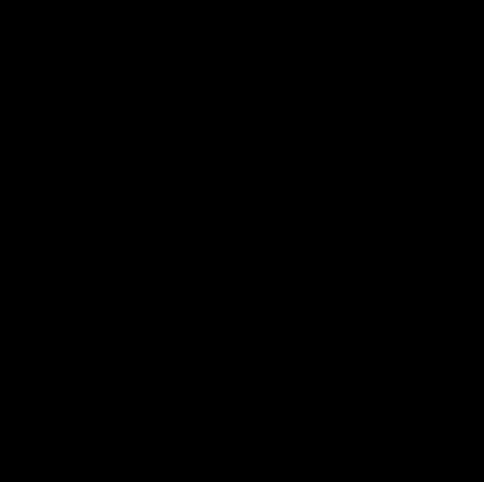

In [24]:
# creating a square black or white depending if is day or night

color = "white" if current_is_day_word == "day" else "black"

# creating the square
fig, ax = plt.subplots(figsize=(6, 6), facecolor=color)
ax.set_facecolor(color)

# formating
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

In [25]:
# I focused on the current data. The hourly and daily dataset are almost what the api provide

In [26]:
# process hourly data

hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(3).ValuesAsNumpy()
hourly_is_day = hourly.Variables(4).ValuesAsNumpy()
hourly_sunshine_duration = hourly.Variables(5).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation"] = hourly_precipitation
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["is_day"] = hourly_is_day
hourly_data["sunshine_duration"] = hourly_sunshine_duration

hourly_dataframe = pd.DataFrame(data = hourly_data)
print("\nHourly data\n", hourly_dataframe)



Hourly data
                          date  temperature_2m  apparent_temperature  \
0   2025-08-05 04:00:00+00:00       22.867500             25.029440   
1   2025-08-05 05:00:00+00:00       23.367500             24.981197   
2   2025-08-05 06:00:00+00:00       23.717501             24.892862   
3   2025-08-05 07:00:00+00:00       22.417501             23.276611   
4   2025-08-05 08:00:00+00:00       21.317501             22.377411   
..                        ...             ...                   ...   
331 2025-08-18 23:00:00+00:00       23.824001             23.904652   
332 2025-08-19 00:00:00+00:00       23.324001             23.712420   
333 2025-08-19 01:00:00+00:00       22.924002             23.324940   
334 2025-08-19 02:00:00+00:00       22.674002             23.245735   
335 2025-08-19 03:00:00+00:00       22.424002             23.124432   

     precipitation  cloud_cover  is_day  sunshine_duration  
0              0.0         57.0     0.0           0.000000  
1          

In [27]:
# process daily data

daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()
daily_sunrise = daily.Variables(1).ValuesInt64AsNumpy()
daily_sunset = daily.Variables(2).ValuesInt64AsNumpy()
daily_daylight_duration = daily.Variables(3).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(4).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(5).ValuesAsNumpy()
daily_precipitation_probability_max = daily.Variables(6).ValuesAsNumpy()
daily_apparent_temperature_max = daily.Variables(7).ValuesAsNumpy()
daily_apparent_temperature_min = daily.Variables(8).ValuesAsNumpy()
daily_temperature_2m_max = daily.Variables(9).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(10).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(11).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["weather_code"] = daily_weather_code
daily_data["sunrise"] = daily_sunrise
daily_data["sunset"] = daily_sunset
daily_data["daylight_duration"] = daily_daylight_duration
daily_data["sunshine_duration"] = daily_sunshine_duration
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["precipitation_probability_max"] = daily_precipitation_probability_max
daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
daily_data["apparent_temperature_min"] = daily_apparent_temperature_min
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["precipitation_hours"] = daily_precipitation_hours

daily_dataframe = pd.DataFrame(data = daily_data)
print("\nDaily data\n", daily_dataframe)



Daily data
                         date  weather_code     sunrise      sunset  \
0  2025-08-05 04:00:00+00:00           3.0  1754387790  1754438779   
1  2025-08-06 04:00:00+00:00          51.0  1754474249  1754525107   
2  2025-08-07 04:00:00+00:00          53.0  1754560708  1754611433   
3  2025-08-08 04:00:00+00:00           0.0  1754647167  1754697758   
4  2025-08-09 04:00:00+00:00           0.0  1754733626  1754784082   
5  2025-08-10 04:00:00+00:00           0.0  1754820085  1754870405   
6  2025-08-11 04:00:00+00:00           0.0  1754906545  1754956727   
7  2025-08-12 04:00:00+00:00           3.0  1754993004  1755043048   
8  2025-08-13 04:00:00+00:00          53.0  1755079462  1755129369   
9  2025-08-14 04:00:00+00:00          53.0  1755165921  1755215689   
10 2025-08-15 04:00:00+00:00           3.0  1755252380  1755302007   
11 2025-08-16 04:00:00+00:00           1.0  1755338838  1755388325   
12 2025-08-17 04:00:00+00:00          51.0  1755425297  1755474640   
13 2025

In [28]:
hourly_dataframe.to_csv('hourly_dataframe.csv', index=False)
daily_dataframe.to_csv('daily_dataframe.csv', index=False)